In [1]:
    import numpy as np

# Données physiques
h = 10  # Coefficient de convection (W/m^2/K)
Aeau_air = 0.0133  # Surface de contact eau-air (m^2)
meau = 0.08  # Masse de l'eau (kg)
ceau = 4186  # Capacité thermique de l'eau (J/kg/K)
Mair_int = 0.0051 * 1005  # Capacité thermique de l'air intérieur (J/K)
Atot = 0.1722  # Surface totale des parois (m^2)
e = 0.014  # Épaisseur des parois (m)
k = 0.025  # Conductivité thermique des parois (W/m/K)

# Capacités thermiques globales
Me = meau * ceau  # Capacité thermique totale de l'eau (J/K)

# Coefficients du polynôme caractéristique
b = (h * Aeau_air / Me +
     k * Atot / (e * Mair_int) +
     h * Aeau_air / Mair_int)

c = (h * Aeau_air * k * Atot) / (e * Me * Mair_int)

# Polynôme caractéristique
coefficients = [1, b, c]  # Coefficients pour r^2 + b*r + c

# Résolution des racines
racines = np.roots(coefficients)

# Affichage des résultats
print("Coefficients du polynôme :")
print(f"b = {b:.4f}")
print(f"c = {c:.4e}")
print("\nRacines du polynôme :")
    print(np.abs(1/racines))


Coefficients du polynôme :
b = 0.0863
c = 2.3827e-05

Racines du polynôme :
[  11.61937675 3611.98430319]


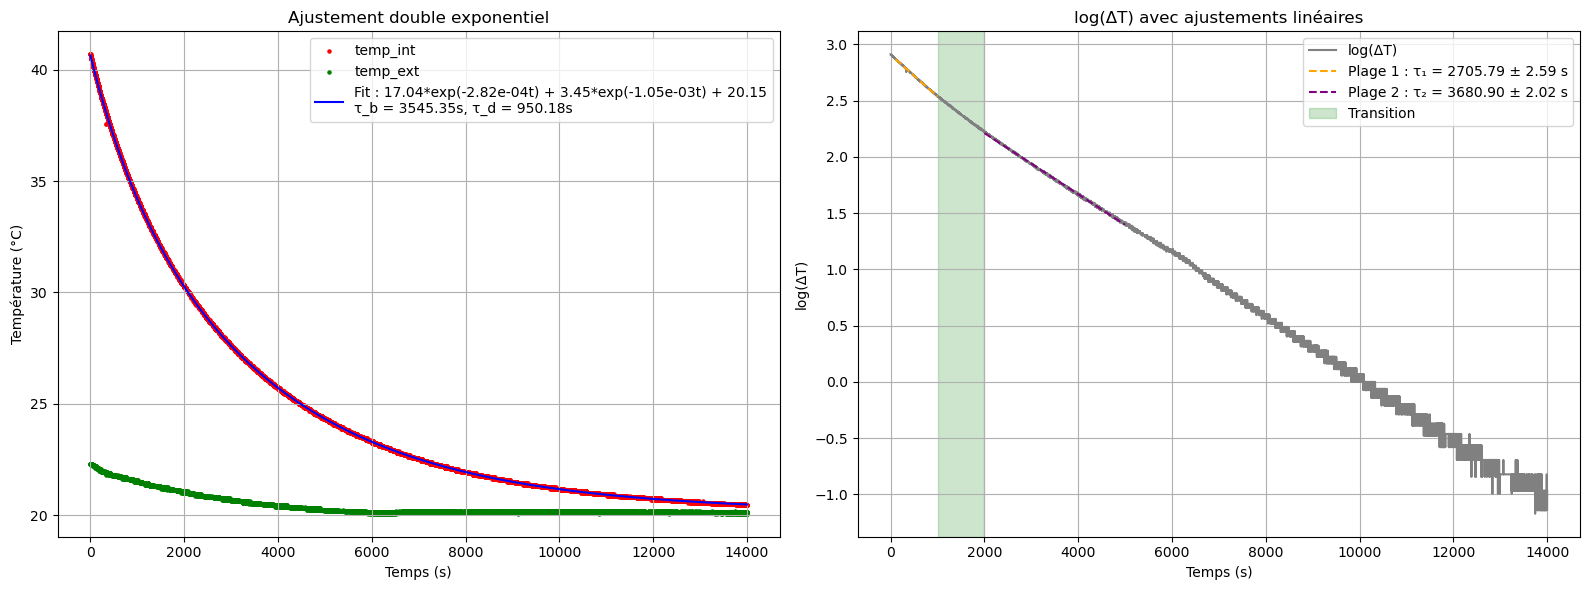

=== Modèle double exponentiel ===
Équation : T(t) = 17.04*exp(-2.82e-04t) + 3.45*exp(-1.05e-03t) + 20.15
Temps caractéristiques : τ_b = 3545.35 s | τ_d = 950.18 s

=== Méthode log-linéaire ===
Plage 1 : τ₁ = 2705.79 ± 2.59 s
Plage 2 : τ₂ = 3680.90 ± 2.02 s


In [3]:

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Charger les données expérimentales depuis le fichier
data = np.loadtxt("DATA.txt")

# Extraire les colonnes

temp_ext = data[:14000, 0]  # Température extérieure
temp_int = data[:14000, 1]  # Température intérieure

# Calcul de Delta T
Text_moyenne = np.mean(temp_ext)  # Moyenne
delta_T = temp_int - temp_ext  # Différence de température

# Créer un vecteur de temps (1 mesure par seconde)
temps = np.arange(len(temp_int))  # en secondes

limite_temps = 277500
masque = temps <= limite_temps  # Créer un masque pour filtrer les données

temps = temps[masque]
delta_T = delta_T[masque]


# --- MODELE DOUBLE EXPONENTIEL ---
def modele_double_expo(t, a, b, c, d, e):
    return a * np.exp(-b * t) + c * np.exp(-d * t) + e

# --- PARAMÈTRES INITIAUX POUR L'AJUSTEMENT ---
p0 = [max(temp_int) - min(temp_int), 1e-4, (max(temp_int) - min(temp_int)) / 2, 1e-4, min(temp_ext)]

# Ajustement global
params_opt, params_cov = curve_fit(modele_double_expo, temps, temp_int, p0=p0, maxfev=5000)
a_opt, b_opt, c_opt, d_opt, e_opt = params_opt

# Temps caractéristiques exponentiels
tau_b = 1 / b_opt
tau_d = 1 / d_opt

# --- CALCUL DU DELTA T ---
delta_T = np.abs(temp_int - temp_ext)

# --- AJUSTEMENTS LOG-LINÉAIRES ---
# Plage 1 : début de décroissance
masque1 = (temps >= 100) & (temps <= 1000)
t1 = temps[masque1]
logT1 = np.log(delta_T[masque1])
(p1, cov1) = np.polyfit(t1, logT1, 1, cov=True)
m1, b1 = p1
dm1 = np.sqrt(cov1[0][0])
tau1 = -1 / m1
dtau1 = np.abs(dm1 / m1**2)

# Plage 2 : fin de décroissance
masque2 = (temps >= 2000) & (temps <= 5000)
t2 = temps[masque2]
logT2 = np.log(delta_T[masque2])
(p2, cov2) = np.polyfit(t2, logT2, 1, cov=True)
m2, b2 = p2
dm2 = np.sqrt(cov2[0][0])
tau2 = -1 / m2
dtau2 = np.abs(dm2 / m2**2)#

# --- GRAPHIQUES ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# --- COURBE EXPONENTIELLE ---
axs[0].scatter(temps, temp_int, label="temp_int", color='red', s=5)
axs[0].scatter(temps, temp_ext, label="temp_ext", color='green', s=5)
axs[0].plot(temps, modele_double_expo(temps, *params_opt),
            label=f"Fit : {a_opt:.2f}*exp(-{b_opt:.2e}t) + {c_opt:.2f}*exp(-{d_opt:.2e}t) + {e_opt:.2f}\n"
                  f"τ_b = {tau_b:.2f}s, τ_d = {tau_d:.2f}s", color='blue')

axs[0].set_title("Ajustement double exponentiel")
axs[0].set_xlabel("Temps (s)")
axs[0].set_ylabel("Température (°C)")
axs[0].legend()
axs[0].grid(True)

# --- COURBE LOG(ΔT) + AJUSTEMENTS ---
axs[1].plot(temps, np.log(delta_T), label="log(ΔT)", color='grey')

axs[1].plot(t1, m1 * t1 + b1, '--', color='orange', label=f"Plage 1 : τ₁ = {tau1:.2f} ± {dtau1:.2f} s")
axs[1].plot(t2, m2 * t2 + b2, '--', color='purple', label=f"Plage 2 : τ₂ = {tau2:.2f} ± {dtau2:.2f} s")

# Zone de transition visuelle
axs[1].axvspan(1000, 2000, color='green', alpha=0.2, label="Transition")

axs[1].set_title("log(ΔT) avec ajustements linéaires")
axs[1].set_xlabel("Temps (s)")
axs[1].set_ylabel("log(ΔT)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("analyse_temp_complet.png", dpi=300, bbox_inches="tight")
plt.show()

# --- AFFICHAGE TERMINAL ---
print("=== Modèle double exponentiel ===")
print(f"Équation : T(t) = {a_opt:.2f}*exp(-{b_opt:.2e}t) + {c_opt:.2f}*exp(-{d_opt:.2e}t) + {e_opt:.2f}")
print(f"Temps caractéristiques : τ_b = {tau_b:.2f} s | τ_d = {tau_d:.2f} s")

print("\n=== Méthode log-linéaire ===")
print(f"Plage 1 : τ₁ = {tau1:.2f} ± {dtau1:.2f} s")
print(f"Plage 2 : τ₂ = {tau2:.2f} ± {dtau2:.2f} s")



